In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import datetime as dt
import pickle
import folium 

# Project overview
 
The premise of this project was to help a non-profit optimize it's placement of canvasing teams around subway stations in Manhattan. The non-profit was planning to have a fundraising gala and wanted to increase it's exposure by getting emails of those interesting in it's mission.

## Retrieve MTA data
NYC subway data is made public through a MTA website. The data is organized at ticker readings of individual turnstiles. The following functions work to retrieve the MTA data for a specific number of weeks. 

In [2]:
def following_saturday(date):
    '''
    Takes a date and returns the date of the Saturday that follows.
    '''
    weekday = pd.to_datetime(date).weekday()
    if weekday == 6:
        day_shift = 6
    else:
        day_shift = 5 - pd.to_datetime(date).weekday()
    sat_date = pd.to_datetime(date) + pd.Timedelta(days=day_shift)
    return sat_date

In [3]:
def select_weeks(date,weeks):
    '''
    Input date as a string in format MM/DD/YYYY. Returns list of dates for turnstile_read
    '''
    if type(date) != str:
        print('Enter date as string')
        return
    #sat = pd.to_datetime(date)
    sat = following_saturday(date)
    
    dates = pd.date_range(sat, periods=weeks, freq='w') + pd.Timedelta(days=-1)
    return list(dates.strftime('%y%m%d'))

In [4]:
def turnstile_read(tlist):
    '''
    Input is list of dates in YYMMDD format, e.g. 200106 for Jan 6 2020
    '''
    base = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    df_list = []
    for date in tlist:
        url = base + str(date) + '.txt'
        df_list.append(pd.read_csv(url))
    return pd.concat(df_list)

In [5]:
def pull_mta_data(date,weeks):
    '''
    Takes a date and number of weeks and returns a dataframe with MTA data
    '''
    
    MTAdata = turnstile_read(select_weeks(date,weeks))
    return MTAdata

In [6]:
raw_mta_data = pull_mta_data('4/1/2019',13)

In [7]:
# Save data in a pickle
with open('raw_mta_data.pickle', 'wb') as to_write:
    pickle.dump(raw_mta_data, to_write)

In [8]:
# Retrieve pickle
with open('raw_mta_data.pickle','rb') as read_file:
    raw_mta_data = pickle.load(read_file)

## Start of Cleaning Data

In [9]:
def clean_columns(df):
    '''
    Tidies the column names. Eliminates whitespace and the /. Makes them lowercase.
    '''
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={'c/a': 'ca'}, inplace=True)
    return df

In [10]:
mta_data = clean_columns(raw_mta_data)
mta_data.columns

Index(['ca', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

In [11]:
mta_data.shape

(2664248, 11)

In [12]:
mta_data.head()

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


In [13]:
def add_date_format(df):
    '''
    Combines the date and time into one
    '''
    df['date_time'] = pd.to_datetime(df.date + ' ' + df.time)
    return df

In [14]:
mta_data = add_date_format(mta_data)

### Scan that all dates are present

In [15]:
mta_data.date.value_counts().sort_index()[70:84]

06/08/2019    29030
06/09/2019    29133
06/10/2019    29351
06/11/2019    29113
06/12/2019    30023
06/13/2019    29276
06/14/2019    29008
06/15/2019    29605
06/16/2019    29322
06/17/2019    29421
06/18/2019    29599
06/19/2019    29614
06/20/2019    29556
06/21/2019    30360
Name: date, dtype: int64

### Check for duplicates

In [16]:
(mta_data
 .groupby(['ca','unit','scp','station','date_time'])
 .entries.count()
 .reset_index()
 .sort_values('entries', ascending=False)
)

,ca,unit,scp,station,date_time,entries
626289,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,2
2178082,R283,R221,00-00-00,167 ST,2019-04-16 04:00:00,2
384181,G009,R151,02-00-04,CONEY IS-STILLW,2019-05-16 17:00:00,2
1749648,R133,R272,00-00-00,28 ST,2019-04-09 13:00:00,2
626294,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-02 17:00:00,2
...,...,...,...,...,...,...
888085,N141,R356,00-00-01,OZONE PK LEFFRT,2019-04-20 00:00:00,1
888086,N141,R356,00-00-01,OZONE PK LEFFRT,2019-04-20 04:00:00,1
888087,N141,R356,00-00-01,OZONE PK LEFFRT,2019-04-20 08:00:00,1
888088,N141,R356,00-00-01,OZONE PK LEFFRT,2019-04-20 12:00:00,1


In [17]:
mta_data.sort_values(['ca','unit','scp','station','date_time'],inplace=True, ascending=True)

In [18]:
mta_data.drop_duplicates(subset=['ca','unit','scp','station','date_time'],keep=False, inplace=True)

### Removed the duplicates

In [19]:
mta_data.shape

(2664136, 12)

### Examine specific turnstiles

In [20]:
mask = (
 (mta_data["ca"] == "R283") &
 (mta_data["unit"] == "R221") & 
 (mta_data["scp"] == "00-00-03") & 
 (mta_data["station"] == "167 ST") &
 (mta_data["date_time"] == pd.to_datetime('04/15/2019 12:00:00'))
)
mta_data[mask]

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time


In [21]:
mask = (
 (mta_data["ca"] == "R283") &
 (mta_data["unit"] == "R221") & 
 (mta_data["scp"] == "00-00-03") & 
 (mta_data["station"] == "167 ST") &
 (mta_data["date"] == '04/16/2019')
)
mta_data[mask]

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time
165907,R283,R221,00-00-03,167 ST,4,IRT,04/16/2019,00:00:00,RECOVR AUD,1511900,378423,2019-04-16 00:00:00
165910,R283,R221,00-00-03,167 ST,4,IRT,04/16/2019,08:00:00,REGULAR,147881,74699,2019-04-16 08:00:00
165911,R283,R221,00-00-03,167 ST,4,IRT,04/16/2019,12:00:00,REGULAR,148630,74930,2019-04-16 12:00:00
165912,R283,R221,00-00-03,167 ST,4,IRT,04/16/2019,16:00:00,REGULAR,149110,75242,2019-04-16 16:00:00
165913,R283,R221,00-00-03,167 ST,4,IRT,04/16/2019,20:00:00,REGULAR,149612,75713,2019-04-16 20:00:00


In [22]:
mta_data[(mta_data.desc == 'RECOVR AUD')]

,ca,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,7062835,2393662,2019-05-18 16:00:00
14,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/20/2019,08:00:00,RECOVR AUD,7064032,2394024,2019-05-20 08:00:00
48,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,6290790,1410938,2019-05-18 16:00:00
58,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/20/2019,08:00:00,RECOVR AUD,6291762,1411151,2019-05-20 08:00:00
92,A002,R051,02-03-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,1233934,4640293,2019-05-18 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
202474,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,04/14/2019,21:00:00,RECOVR AUD,2872,62,2019-04-14 21:00:00
204973,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,06/05/2019,17:00:00,RECOVR AUD,2907,62,2019-06-05 17:00:00
202515,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/14/2019,17:00:00,RECOVR AUD,5554,374,2019-04-14 17:00:00
202516,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/14/2019,21:00:00,RECOVR AUD,5554,374,2019-04-14 21:00:00


def min_max_turnstiles(data,data_point):
    data_grouped = (data
                    .groupby(['ca','unit','scp','station','date'])
                    [data_point].agg(['max','min']))
    data_grouped['daily_'+data_point] = data_grouped['max'] - data_grouped['min']
    return data_grouped.reset_index()
min_max_turnstiles(mta_data,'entries')

# Calculate daily usage

In [23]:
def min_max_turnstiles(data):
    '''
    Takes in a dataframe of MTA data calculates the daily entries and exits and also combines them.
    '''
    data_grouped = (data
                    .groupby(['ca','unit','scp','station','date'])
                    [['entries','exits']].agg(['max','min']))
    data_grouped['daily_entries'] = data_grouped.entries['max'] - data_grouped.entries['min']
    data_grouped['daily_exits'] = data_grouped.exits['max'] - data_grouped.exits['min']
    data_grouped['daily_usage'] = data_grouped['daily_entries'] + data_grouped['daily_exits']
    
    return data_grouped.reset_index()

In [24]:
mta_daily_usage = min_max_turnstiles(mta_data)

# Continued Cleaning

In [25]:
mta_daily_usage.sort_values('daily_usage')

ca  unit       scp        station        date     entries  \
                                                                 max   
440637  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/28/2019        5554   
310155   R169  R168  01-05-01          96 ST  04/20/2019           0   
310156   R169  R168  01-05-01          96 ST  04/21/2019           0   
310157   R169  R168  01-05-01          96 ST  04/22/2019           0   
78151    J002  R460  00-05-01       MARCY AV  06/28/2019           0   
...       ...   ...       ...            ...         ...         ...   
369960   R311  R053  00-00-00    3 AV-149 ST  06/19/2019  1258666495   
163001   N300  R113  01-00-04           7 AV  04/24/2019  1835264364   
380259   R405  R447  01-00-00     CYPRESS AV  04/18/2019  2013307514   
156060   N207  R104  00-00-00         167 ST  06/14/2019  1828704206   
355150   R252  R180  00-03-02         103 ST  04/17/2019  2097051992   

                       exits            daily_entries daily_exits daily_usage  
             min         max        min                                        
440637      5554         379        379             0           0           0  
310155         0        1554       1554             0           0           0  
310156         0        1554       1554             0           0           0  
310157         0        1554       1554             0           0           0  
78151          0         351        351             0           0           0  
...          ...         ...        ...           ...         ...         ...  
369960  88839683  1476890881  123244243    1169826812  1353646638  2523473450  
163001       572   773055193        106    1835263792   773055087  2608318879  
380259   1933614   838917930    3865521    2011373900   835052409  2846426309  
156060   9687851  1828766425    7175686    1819016355  1821590739  3640607094  
355150  25412483  1711133642   43698784    2071639509  1667434858  3739074367  

[440638 rows x 12 columns]

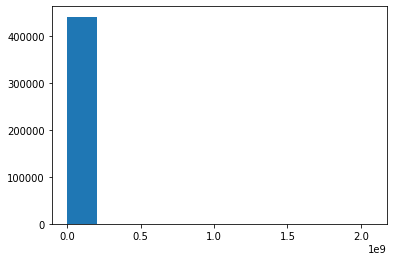

In [26]:
plt.hist(mta_daily_usage.daily_entries,bins=10);

In [27]:
mta_daily_usage.shape

(440638, 12)

In [28]:
mta_daily_usage.loc[(mta_daily_usage.daily_entries > 6000)].count().max()

807

In [29]:
mta_daily_usage.loc[(mta_daily_usage.daily_exits > 6000)].count().max()

1602

### Drop outliers

In [30]:
mta_daily_usage = mta_daily_usage.drop(mta_daily_usage.loc[(mta_daily_usage.daily_entries > 10000)].index, axis=0, errors='ignore')

In [31]:
mta_daily_usage.loc[(mta_daily_usage.daily_entries > 6000)].count().max()

295

In [32]:
mta_daily_usage = mta_daily_usage.drop(mta_daily_usage.loc[(mta_daily_usage.daily_exits > 10000)].index, axis=0, errors='ignore')

In [33]:
mta_daily_usage.loc[(mta_daily_usage.daily_exits > 6000)].count().max()

1003

In [34]:
with open('mta_daily_usage.pickle', 'wb') as to_write:
    pickle.dump(mta_daily_usage, to_write)

## Turnstile investigation

In [35]:
list(mta_daily_usage.groupby(['ca','unit','scp','station']).count().index.unique())

/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


[('A002', 'R051', '02-00-00', '59 ST'),
 ('A002', 'R051', '02-00-01', '59 ST'),
 ('A002', 'R051', '02-03-00', '59 ST'),
 ('A002', 'R051', '02-03-01', '59 ST'),
 ('A002', 'R051', '02-03-02', '59 ST'),
 ('A002', 'R051', '02-03-03', '59 ST'),
 ('A002', 'R051', '02-03-04', '59 ST'),
 ('A002', 'R051', '02-03-05', '59 ST'),
 ('A002', 'R051', '02-03-06', '59 ST'),
 ('A002', 'R051', '02-05-00', '59 ST'),
 ('A002', 'R051', '02-05-01', '59 ST'),
 ('A002', 'R051', '02-06-00', '59 ST'),
 ('A006', 'R079', '00-00-00', '5 AV/59 ST'),
 ('A006', 'R079', '00-00-01', '5 AV/59 ST'),
 ('A006', 'R079', '00-00-02', '5 AV/59 ST'),
 ('A006', 'R079', '00-00-03', '5 AV/59 ST'),
 ('A006', 'R079', '00-00-04', '5 AV/59 ST'),
 ('A006', 'R079', '00-03-00', '5 AV/59 ST'),
 ('A006', 'R079', '00-03-01', '5 AV/59 ST'),
 ('A006', 'R079', '00-03-02', '5 AV/59 ST'),
 ('A007', 'R079', '01-05-00', '5 AV/59 ST'),
 ('A007', 'R079', '01-05-01', '5 AV/59 ST'),
 ('A007', 'R079', '01-06-00', '5 AV/59 ST'),
 ('A007', 'R079', '01-06-

In [36]:
def number_of_turnstiles(df):
    return len(df.groupby(['ca','unit','scp','station']).count().index.unique())

In [37]:
len(mta_daily_usage.station.unique())

378

In [38]:
number_of_turnstiles(mta_daily_usage)

4912

In [39]:
def single_turnstile(df, number):
    '''
    Inputs a dataframe from MTA and a number to select the data for a single turnstile. The input number is kind of
    arbitrary. This is just a quick way to pick a random turnstile.
    
    '''
    ts_index = list(df.groupby(['ca','unit','scp','station']).count().index.unique())
    ts = ts_index[number]
    print(ts)
    return df.loc[(df.ca == ts[0]) & (df.unit == ts[1]) & (df.scp == ts[2]) & (df.station == ts[3])]

In [40]:
def turnstile_plot(mta_data,number):
    
    ts_df = single_turnstile(mta_data,number)
    x = ts_df.date
    y = ts_df.daily_entries
    plt.plot(x, y)
    plt.xlabel('date')
    plt.ylabel('Daily Entries')
    plt.xticks(rotation=45)
    plt.title('Turnstile usage');

('A002', 'R051', '02-00-01', '59 ST')


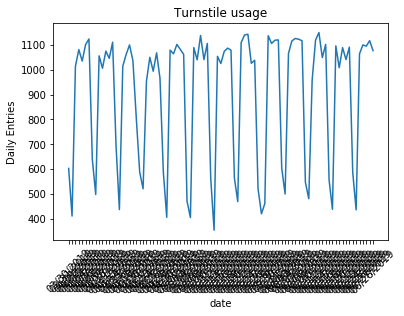

In [41]:
turnstile_plot(mta_daily_usage,1)

In [42]:
mta_daily_usage

ca  unit       scp        station        date  entries           \
                                                              max      min   
0        A002  R051  02-00-00          59 ST  03/30/2019  6999796  6999064   
1        A002  R051  02-00-00          59 ST  03/31/2019  7000433  6999957   
2        A002  R051  02-00-00          59 ST  04/01/2019  7001895  7000528   
3        A002  R051  02-00-00          59 ST  04/02/2019  7003466  7002087   
4        A002  R051  02-00-00          59 ST  04/03/2019  7005109  7003680   
...       ...   ...       ...            ...         ...      ...      ...   
440633  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/24/2019     5554     5554   
440634  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/25/2019     5554     5554   
440635  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/26/2019     5554     5554   
440636  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/27/2019     5554     5554   
440637  TRAM2  R469  00-05-01  RIT-ROOSEVELT  06/28/2019     5554     5554   

          exits          daily_entries daily_exits daily_usage  
            max      min                                        
0       2373837  2373568           732         269        1001  
1       2374065  2373867           476         198         674  
2       2374553  2374095          1367         458        1825  
3       2375094  2374579          1379         515        1894  
4       2375532  2375133          1429         399        1828  
...         ...      ...           ...         ...         ...  
440633      379      379             0           0           0  
440634      379      379             0           0           0  
440635      379      379             0           0           0  
440636      379      379             0           0           0  
440637      379      379             0           0           0  

[439992 rows x 12 columns]

In [43]:
def station_usage(mta_dataframe,column='daily_usage'):
    '''
    Groups by station and calulates the sum of one of the columns. 
    '''
    return mta_dataframe.groupby(['station'])[column].sum().sort_values(ascending=False)

In [44]:
(station_usage(mta_daily_usage,'daily_usage').head(15).sum()
 /station_usage(mta_daily_usage,'daily_usage').sum())

0.2640973286015324

In [45]:
station_names = pd.Series(['34th St-Penn Station'
 ,'Grand Central-42 St'
 ,'34th St-Herald Square'
 ,'14th St-Union Square'
 ,'23rd St'
 ,'Times Square-42nd St'
 ,'42nd St-Port Authority'
 ,'Fulton St'
 ,'86th St'
 ,'125th St'
 ,'Canal St'
 ,'59th St Columbus'
 ,'59th St'
 ,'Rockefeller Center'
 ,'96th St'
 ,'14th St'
 ,'Chambers St'
 ,'PATH-World Trade Center'
 ,'72nd St'
 ,'Flushing Main St'])

In [46]:
number_of_stations = 15


total_station_usage = pd.DataFrame({
    'avg_daily' : station_usage(mta_daily_usage,'daily_usage').head(number_of_stations)//91,
    'station_name': pd.Categorical(station_names[0:number_of_stations])
})

total_station_usage

,avg_daily,station_name
station,,
34 ST-PENN STA,257028,34th St-Penn Station
GRD CNTRL-42 ST,218080,Grand Central-42 St
34 ST-HERALD SQ,185245,34th St-Herald Square
14 ST-UNION SQ,158625,14th St-Union Square
23 ST,154179,23rd St
TIMES SQ-42 ST,149942,Times Square-42nd St
42 ST-PORT AUTH,145950,42nd St-Port Authority
FULTON ST,145122,Fulton St
86 ST,130991,86th St


## Plotting

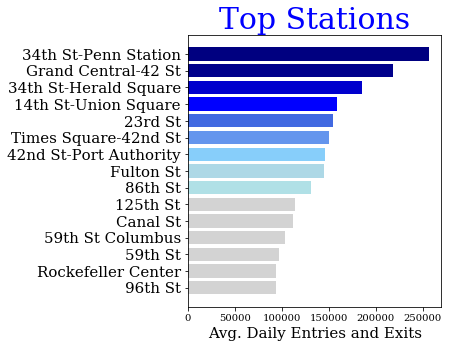

In [47]:
plt.figure(figsize=[10, 5])

plt.subplot(1, 2, 2)
plt.title('Top Stations',family='serif',fontsize=30, color='b',horizontalalignment='center')
plt.barh(total_station_usage.station_name,total_station_usage.avg_daily,
        color=['navy','darkblue','mediumblue','blue','royalblue',
               'cornflowerblue','lightskyblue','lightblue','powderblue','lightgray',
               'lightgray','lightgray','lightgray','lightgray','lightgray']) 

plt.xticks(family='serif', fontsize=10)
plt.yticks(family='serif', fontsize=15)
plt.gca().invert_yaxis()
plt.xlabel('Avg. Daily Entries and Exits', family='serif', fontsize=15);
plt.savefig('topstation.png', transparent=True)

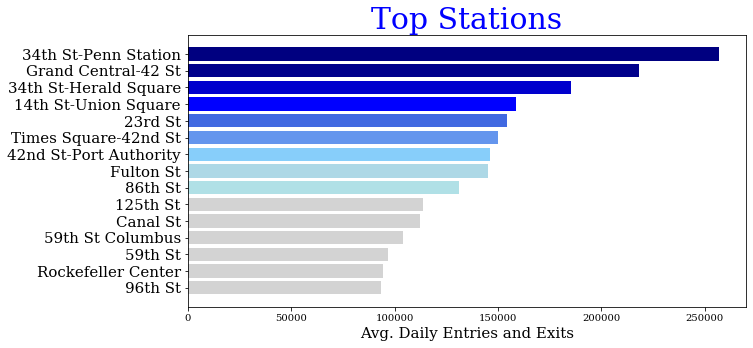

In [48]:
fig, ax = plt.subplots(figsize=[10, 5])


ax.barh(total_station_usage.station_name,total_station_usage.avg_daily,
        color=['navy','darkblue','mediumblue','blue','royalblue',
               'cornflowerblue','lightskyblue','lightblue','powderblue','lightgray',
               'lightgray','lightgray','lightgray','lightgray','lightgray']) 
ax.set_title('Top Stations',family='serif',fontsize=30, color='b',horizontalalignment='center')
plt.xticks(family='serif', fontsize=10)
plt.yticks(family='serif', fontsize=15)
plt.gca().invert_yaxis()
plt.xlabel('Avg. Daily Entries and Exits', family='serif', fontsize=15);
plt.savefig('topstation.svg',bbox_inches = "tight", transparent=True)

In [49]:
total_station_entries = station_usage(mta_daily_usage,'daily_entries').head(20)
total_station_entries//91

station
34 ST-PENN STA     133393
GRD CNTRL-42 ST    115800
34 ST-HERALD SQ     93248
23 ST               86794
42 ST-PORT AUTH     82136
14 ST-UNION SQ      79047
FULTON ST           77459
TIMES SQ-42 ST      72820
86 ST               68599
125 ST              63794
CANAL ST            60816
59 ST COLUMBUS      54658
96 ST               53197
59 ST               50143
14 ST               47379
CHAMBERS ST         43881
FLUSHING-MAIN       43750
47-50 STS ROCK      43722
JKSN HT-ROOSVLT     41546
PATH NEW WTC        41449
Name: daily_entries, dtype: int64

In [50]:
def station_usage_over_time(mta_dataframe):
    return mta_dataframe.groupby(['station','date'])['daily_usage'].sum().reset_index()

station_usage_over_time(mta_daily_usage)

,station,date,daily_usage
0,1 AV,03/30/2019,24885
1,1 AV,03/31/2019,19854
2,1 AV,04/01/2019,36187
3,1 AV,04/02/2019,36741
4,1 AV,04/03/2019,36608
...,...,...,...
34309,ZEREGA AV,06/24/2019,4944
34310,ZEREGA AV,06/25/2019,4786
34311,ZEREGA AV,06/26/2019,5225
34312,ZEREGA AV,06/27/2019,4807


In [51]:
def single_station_data(mta_dataframe,station):
    station_data = station_usage_over_time(mta_dataframe)
    return station_data[station_data.station == station]

In [52]:
penn = single_station_data(mta_daily_usage,'34 ST-PENN STA')

In [53]:
def station_single_week_plot(mta_dataframe,station,date,color =None):
    station_data = single_station_data(mta_dataframe,station)
    station_data.index = station_data.date
    
    last_day = following_saturday(date) + pd.Timedelta(days=1)
    first_day = last_day + pd.Timedelta(days=-6)
    dates = pd.date_range(first_day,last_day,freq='d').strftime('%m/%d/%Y')
    week_label = 'week of '+dates[0][0:5]

    
    plt.plot(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
             ,station_data.daily_usage[dates],label=week_label, c=color)
    plt.xticks(fontsize=15, family='serif', rotation=0)
    plt.yticks(fontsize=15, family='serif')

In [54]:
def station_weeks_plot(mta_dataframe,station,date,weeks):
    dates = pd.date_range(date,periods=weeks,freq='w').strftime('%m/%d/%Y')
    for date in dates:
        station_single_week_plot(mta_daily_usage,station,date)

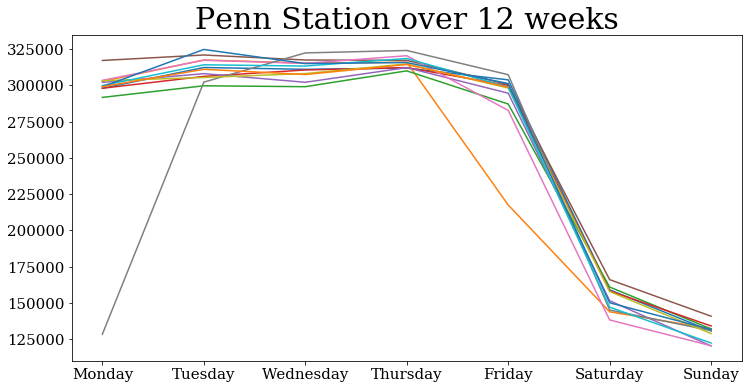

In [55]:
plt.figure(figsize=(12,6))
station_weeks_plot(mta_daily_usage,'34 ST-PENN STA','4/1/2019',12)
plt.title('Penn Station over 12 weeks',fontsize=30,family='serif');
bottom, top = plt.ylim()
plt.savefig('pennstation.svg',bbox_inches = "tight", transparent=False)
#plt.legend();

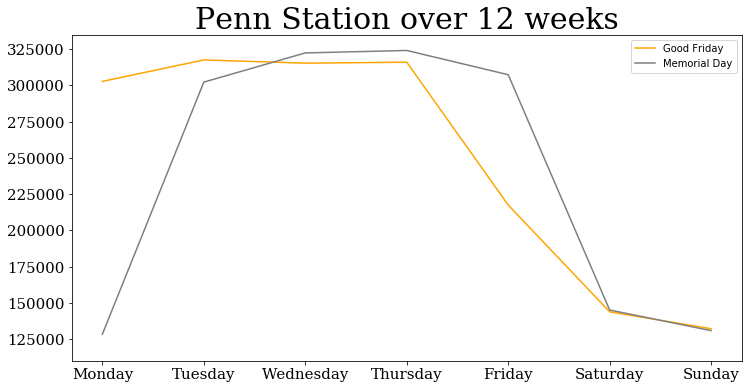

In [56]:
plt.figure(figsize=(12,6))
station_single_week_plot(mta_daily_usage,'34 ST-PENN STA','4/19/2019','orange')
station_single_week_plot(mta_daily_usage,'34 ST-PENN STA','5/27/2019','#7f7f7f')
plt.title('Penn Station over 12 weeks',fontsize=30,family='serif');
plt.ylim(bottom,top)
plt.legend(['Good Friday','Memorial Day']);
plt.savefig('pennstationaberations.svg',bbox_inches = "tight", transparent=False)

In [57]:
date = '5/18/2019'

In [58]:
station_data['dayoftheweek'] = pd.Series(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

NameError: name 'station_data' is not defined

In [59]:
dates = pd.date_range(date,periods=7,freq='d').strftime('%m/%d/%Y')
dates[0]
penn.index = penn.date
penn.daily_usage[dates]
penn
    

,station,date,daily_usage
date,,,
03/30/2019,34 ST-PENN STA,03/30/2019,170919
03/31/2019,34 ST-PENN STA,03/31/2019,126441
04/01/2019,34 ST-PENN STA,04/01/2019,301761
04/02/2019,34 ST-PENN STA,04/02/2019,299420
04/03/2019,34 ST-PENN STA,04/03/2019,303930
...,...,...,...
06/24/2019,34 ST-PENN STA,06/24/2019,299051
06/25/2019,34 ST-PENN STA,06/25/2019,311040
06/26/2019,34 ST-PENN STA,06/26/2019,307429


## Making Maps

In [60]:
map_raw = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv', usecols=['Stop Name','GTFS Latitude','GTFS Longitude'])

In [61]:
city_map = folium.Map(location=[40.738, -73.98],zoom_start=11,tiles='OpenStreetMap')

In [62]:
map_keep = pd.DataFrame(columns=['Stop Name','GTFS Latitude','GTFS Longitude'])

In [63]:
map_keep = map_keep.append(map_raw.iloc[[163,402,11,13,162,14,37,152,17,160,156,34,165,104,447,225,267,171]],ignore_index=True)

In [64]:
college = pd.read_csv('COLLEGE_UNIVERSITY.csv',usecols=['the_geom','NAME'])

In [65]:
college = pd.concat([college,pd.DataFrame(columns=['Latitude','Longitude'])])

/Users/nkfoster/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [66]:
for ii in range(len(college.the_geom)):
    x=college.the_geom.iloc[ii]
    (lon,lat)=x.split('(')[1].split(')')[0].split(' ')
    college.Latitude.iat[ii] = float(lat)
    college.Longitude.iat[ii] = float(lon)
for idx, row in map_keep.iterrows():
    folium.CircleMarker(location=(row['GTFS Latitude'],row['GTFS Longitude']),radius=8,color='#1D7DF9',tooltip=row['Stop Name'],fill=False).add_to(city_map)
#comment out the following for loop if you want just the map w/ subway stations, no schools
for _,row in college.iterrows():
    folium.CircleMarker(location=(row['Latitude'],row['Longitude']),radius=2,color='#F93E1D',tooltip=row['NAME'],fill=True).add_to(city_map)

In [67]:
city_map

In [68]:
city_map.save('stations_schools.html')